# 1) Import the necessary libraries

In [109]:
import numpy as np
import pandas as pd
import math
from sklearn import model_selection
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 2) Read the data as a data frame

In [2]:
dataframe = pd.read_csv('bank-full.csv')

In [4]:
dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# 3) Perform basic EDA which should include the following and print out your insights at every step.
## a) Shape of the data

In [5]:
dataframe.shape

(45211, 17)

## b) Data type of each attribute

In [6]:
dataframe.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

## c) Checking the presence of missing values.

In [7]:
dataframe.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

## d) 5 Point summary of numerical attributes

In [8]:
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


## e) Checking the presence of outliers.
Yes Outliers are present in this data.

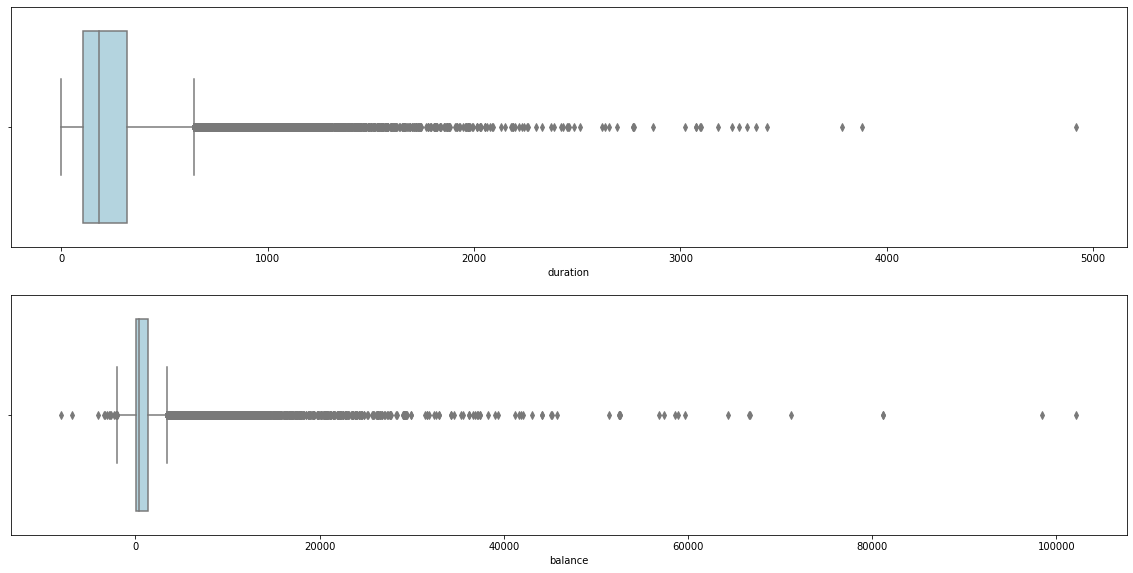

In [9]:
plt.figure(figsize= (20,15))
plt.subplot(3,1,1)
sns.boxplot(x= dataframe.duration, color='lightblue')

plt.subplot(3,1,2)
sns.boxplot(x= dataframe.balance, color='lightblue')

plt.show()

In [69]:
dataframe.groupby(["Target"]).count() 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
Target,,,,,,,,,,,,,,,,
no,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922
yes,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289


# 4) Prepare the data to train a model – check if data types are appropriate, get rid of the missing values etc.
## Data Preprocessing.
for this lets take a copy of the actual dataset first.

In [12]:
dataframe_copy = dataframe.copy(deep=True)

In [55]:
#There are negative numbmers in 'balance' and 'pdays' maybe typing error. Because bank balance cannot be negative and
#number of days after a call cannot be negative.
# Convert to non-negative using .abs function

dataframe_copy['balance'] = dataframe_copy['balance'].abs()
dataframe_copy['pdays'] = dataframe_copy['pdays'].abs()

In [56]:
dataframe_copy.describe(include= 'all')

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,Target
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,11,3,3,2,NaN,2,2,NaN,12,NaN,NaN,NaN,NaN,3,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,NaN,may,NaN,NaN,NaN,NaN,other,no
freq,NaN,10020,27214,25059,44396,NaN,25130,37967,NaN,13766,NaN,NaN,NaN,NaN,38799,39922
mean,40.936210,NaN,NaN,NaN,NaN,1415.196081,NaN,NaN,15.806419,NaN,258.163080,2.763841,41.832563,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3020.529906,NaN,NaN,8.322476,NaN,257.527812,3.098021,99.456849,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,0.000000,1.000000,1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,137.000000,NaN,NaN,8.000000,NaN,103.000000,1.000000,1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,485.000000,NaN,NaN,16.000000,NaN,180.000000,2.000000,1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1436.000000,NaN,NaN,21.000000,NaN,319.000000,3.000000,1.000000,0.000000,NaN,NaN


In [32]:
dataframe_copy.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

As we can see there is no missing value in this dataset. So we don't need to replace any nan value with mean/median.
But there are unknown values in "job", "education", "poutcome" and "contact". Since "contact" column will not have any impact on our analysis. So we will drop it. 

In [35]:
dataframe_copy = dataframe_copy.drop('contact', axis = 1)

In [36]:
dataframe_copy.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58.0,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1,no,no,5,may,198,1,-1,0,unknown,no


In [41]:
for value in ['job','education','poutcome','marital','default','housing','loan','month']:
    print(value,":", sum(dataframe_copy[value] == 'unknown'))

job : 288
education : 1857
poutcome : 36959
marital : 0
default : 0
housing : 0
loan : 0
month : 0


As we can see that there are few categorical variables which are having "unknown" value. Lets replace all of them with most requently occured values. But in case of 'poutcome', most occured value is 'unknown'. So lets replace that with 'other'.

In [47]:
for value in ['job','education']:
    replaceValue = dataframe_copy.describe(include='all')[value][2]
    dataframe_copy[value][dataframe_copy[value]=='unknown'] = replaceValue
for value in ['poutcome']:
    dataframe_copy[value][dataframe_copy[value]=='unknown'] = 'other'


C:\Users\Desktop\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Desktop\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [48]:
for value in ['job','education','poutcome','marital','default','housing','loan','month']:
    print(value,":", sum(dataframe_copy[value] == 'unknown'))

job : 0
education : 0
poutcome : 0
marital : 0
default : 0
housing : 0
loan : 0
month : 0


# 5) Train a few standard classification algorithms, note and comment on their performances across different classification metrics.
## 1.Logistic Regression - model building

In [49]:
## Define X and Y variables
X = dataframe_copy.drop('Target', axis=1)
Y = dataframe_copy[['Target']]

In [50]:
#Convert categorical vriables to dummy variables
X = pd.get_dummies(X, drop_first=True)

In [51]:
##Split into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

In [59]:
#Build the logistic regression model
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

C:\Users\Desktop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Desktop\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
model = LogisticRegression()
model.fit(X_train, y_train)
model_score = model.score(X_test, y_test)
y_predict = model.predict(X_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_predict))

C:\Users\Desktop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Desktop\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9018726039516367
[[11681   306]
 [ 1025   552]]


In [67]:
# summarize the fit of the model
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

          no       0.92      0.97      0.95     11987
         yes       0.64      0.35      0.45      1577

    accuracy                           0.90     13564
   macro avg       0.78      0.66      0.70     13564
weighted avg       0.89      0.90      0.89     13564



## 2. K nearest neighbours

In [64]:
from sklearn.neighbors import KNeighborsClassifier
NNH = KNeighborsClassifier(n_neighbors= 3 , weights = 'distance')
NNH.fit(X_train, y_train)

C:\Users\Desktop\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')

In [65]:
predicted_labels = NNH.predict(X_test)
print(metrics.confusion_matrix(y_test, predicted_labels))

[[11395   592]
 [ 1124   453]]


In [66]:
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

          no       0.91      0.95      0.93     11987
         yes       0.43      0.29      0.35      1577

    accuracy                           0.87     13564
   macro avg       0.67      0.62      0.64     13564
weighted avg       0.85      0.87      0.86     13564



# 6)Build the ensemble models and compare the results with the base models. Note: Random forest can be used only with Decision trees.
## 1.Decision Tree model

In [80]:
model_entropy=DecisionTreeClassifier(criterion='entropy')

In [81]:
model_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [82]:
model_entropy.score(X_train, y_train)  # performance on train data

1.0

In [83]:
model_entropy.score(X_test, y_test)  # performance on test data

0.8695075199056326

#### There is overfitting in the model due to which the test accuracy is not that good.
Regularize/prune the decision tree by limiting the max. depth of trees and print the accuracy.

In [84]:
clf_pruned = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [85]:
preds_pruned = clf_pruned.predict(X_test)
preds_pruned_train = clf_pruned.predict(X_train)

In [86]:
print(accuracy_score(y_test,preds_pruned))
print(accuracy_score(y_train,preds_pruned_train))

0.8997345915659097
0.900748886150346


In [87]:
acc_DT = accuracy_score(y_test, preds_pruned)

In [92]:
xvar = dataframe_copy.drop('Target', axis=1)
feature_cols = xvar.columns

In [93]:
## Calculating feature importance

feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)


feat_imp_dict = dict(zip(feature_cols, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.sort_values(by=0, ascending=False)

,0
education,0.680329
age,0.000000
job,0.000000
marital,0.000000
default,0.000000
balance,0.000000
housing,0.000000
loan,0.000000
day,0.000000
month,0.000000


In [95]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': acc_DT})
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

,Method,accuracy
0,Decision Tree,0.899735


## 2.Random forest model.

In [75]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_train, y_train)

C:\Users\Desktop\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
pred_RF = rfcl.predict(X_test)
acc_RF = accuracy_score(y_test, pred_RF)

In [96]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'accuracy': [acc_RF]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf
resultsDf

,Method,accuracy
0,Decision Tree,0.899735
0,Random Forest,0.901651


## 3. Adaboost Ensemble technique

In [97]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier( n_estimators= 100, learning_rate=0.1, random_state=22)
abcl = abcl.fit(X_train, y_train)

C:\Users\Desktop\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [98]:
pred_AB =abcl.predict(X_test)
acc_AB = accuracy_score(y_test, pred_AB)

In [100]:
tempResultsDf = pd.DataFrame({'Method':['Adaboost'], 'accuracy': [acc_AB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf
resultsDf

,Method,accuracy
0,Decision Tree,0.899735
0,Random Forest,0.901651
0,Adaboost,0.896196
0,Adaboost,0.896196


## 4.Bagging Classifier algo

In [102]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(X_train, y_train)

C:\Users\Desktop\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [103]:
pred_BG =bgcl.predict(X_test)
acc_BG = accuracy_score(y_test, pred_BG)

In [104]:
tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'accuracy': [acc_BG]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf
resultsDf

,Method,accuracy
0,Decision Tree,0.899735
0,Random Forest,0.901651
0,Adaboost,0.896196
0,Adaboost,0.896196
0,Bagging,0.900472


## 5.Gradient boosting.

In [106]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22)
gbcl = gbcl.fit(X_train, y_train)

C:\Users\Desktop\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [107]:
pred_GB =gbcl.predict(X_test)
acc_GB = accuracy_score(y_test, pred_GB)

In [108]:
tempResultsDf = pd.DataFrame({'Method':['Gradient Boost'], 'accuracy': [acc_GB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf
resultsDf

,Method,accuracy
0,Decision Tree,0.899735
0,Random Forest,0.901651
0,Adaboost,0.896196
0,Adaboost,0.896196
0,Bagging,0.900472
0,Gradient Boost,0.903937


# 7) Compare performances of all the models.

All models perfomed almost similar for this dataset. Approx 90% accuracy each model provided.Since False postive are more 
in KNN algo, So Logistic regression is little bit better than KNN. In terms of Ensembe techniques models, there is less than 1% of accuracy difference among all models. So all models performed equally good for this dataset.